# __Capstone Project: The Battle of Neighborhoods__
## *Opening a Japanese restaurant in New York*

## __1. Introduction__

New York City is perhaps the most difficult market in which to open a restaurant. Businesses must distinguish themselves from countless others — both new and old — diners’ tastes are constantly evolving and the rent is, well, too damn high. One trend that has picked up steam in the past year or two in the Big Apple is the opening of Japanese chain (or mini-chain) restaurants. These restaurants have all seized on growth opportunities in New York and diners have been quick to gravitate towards them (Embricos, 2018).

This Capstone project explores different neighbourhoods in New York, and attempts to answer the following business problem: "*If investor is looking to open a new Japanese restaurant, where would you recommend that they open it?*". 

This project might be of interest to potentional *business investors* specilaizing in Japanese cuisine/ restaurant chains, as well as to aspiring *Data Scientists*, who want to learn how to implement some of the most common Exploratory Data Analysis techniques to obtain necessary data, analyze it and, finally to be able to explain your insights in a compelling story.

## __2. Data__

For this project we need the following data:

1. New York City data that contains all Boroughs and Neighbourhoods along with their latitudes and longitudes. <br>
Data Source: https://cocl.us/new_york_dataset

2. Median price per square foot for each Neighbourhood in NYC. <br>
Data Source: https://www.zumper.com/blog/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/

2. Data related to locations and ratings of Japanese restaurants in NYC. <br>
Data Source: **Foursquare API**

## __3. Methodology__

- import all required libraries

- obtain information about NYC boroughs/neighbourhoods along with their *coordinates* (using **requests** library) from https://cocl.us/new_york_dataset and load it into a data frame

- obtain information about *medium rental Price per Sq Foot* for each NYC neighbourhood from https://www.zumper.com/blog/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/ and load it into a data frame (using **BeautifulSoup** package)

- merge the above data frames on their Neighbourhood value (note that not all neighbourhoods had info on the rental price in the area, so there will be some data cleansing steps required along the way)

- next, we are going to start utilizing the **Foursquare API** to explore the neighborhoods and segment them:

    1. define Foursquare credentials and version
    2. define a function **get_venues** that returns top 100 venues for a Neighbourhood within a radius of 500 meters (using url to fetch data from Foursquare API)
    3. analyze how many Japanese restaurants are there in each Neighbourhood and borough
        - prepare a list that contains Japanese restaurants using **get_venues** function
        - calculate how many Japanese restaurants are there in each Neighbourhood
        - merge the new data with the data frame from the previous step on Neighbourhoods to link the number of Japanese restaurants in the Neighbourhood to its coordinates and median rental price per sq foot
        - data cleansing and pre-processing to prepare data frame for clustering


- run clustering on the final data frame containing Neighbourhoods, the medium rental price per sq foot and total number of Japanese restaurants in the area using **K-means algorithm** (set number of clusters = 5)

- add clustering labels to the final data frame

- visualize the results

    1. use **geopy** library to get the latitude and longitude values of New York City
    2. create map to visualize clusters
    3. examine the clusters



First, let's import all required libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # library for data analsysis

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Too see full dataframe...
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1j             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py

## _Data Preparation_

>Now let's define a function that will return a __data frame of NYC boroughs/neighbourhoods along with their coordinates__.

In [2]:
def get_new_york_data():
    
    url = 'https://cocl.us/new_york_dataset'
    response = requests.get(url).json()
    # all data is present in features key
    features = response['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighbourhood_name = data['properties']['name']
        neighbourhood_latlon = data['geometry']['coordinates']
        neighbourhood_lat = neighbourhood_latlon[1]
        neighbourhood_lon = neighbourhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)
    return new_york_data

In [3]:
ny_data = get_new_york_data()
ny_data

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [4]:
ny_data.shape

(306, 4)

>Now let's obtain information about the __Median Price per Sq Foot for every NYC neighbourhood__. For more complicated cases of web scraping BeautifulSoup package is utilized. 

In [5]:
!pip install bs4
from bs4 import BeautifulSoup

     |████████████████████████████████| 122kB 5.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


>Use the requests library to download the webpage https://www.zumper.com/blog/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/. Save the text of the response as a variable named html_data.

In [6]:
url = "https://www.zumper.com/blog/nyc-by-square-foot-see-which-neighborhood-gets-you-the-most-space-for-your-money/"
html_data  = requests.get(url).text

>Parse the html data using BeautifulSoup.

In [7]:
soup = BeautifulSoup(html_data,"html5lib")

>Using beautiful soup extract the table with the list of Median Price per Sq Foot for every NYC neighbourhood and store it into a dataframe named **df_price**. 

In [8]:
tables = soup.find_all('table')
for index,table in enumerate(tables):
    if ("Median Price Per Sq Foot" in str(table)):
        table_index = index
print(table_index)

0


In [9]:
df_price = pd.DataFrame(columns=["Neighbourhood", "Median Price Per Sq Foot"])

for row in tables[0].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        neighbourhood =col[0].text.strip()
        price =col[1].text.strip()
        df_price = df_price.append({"Neighbourhood":neighbourhood, "Median Price Per Sq Foot":price}, ignore_index=True)

df_price

,Neighbourhood,Median Price Per Sq Foot
0,West Village,$7.68
1,Tribeca,$7.64
2,NoMad,$7.63
3,Central Park,$7.53
4,NoHo,$7.38
5,Koreatown,$7.16
6,Flatiron District,$7.10
7,Bowery,$7.09
8,Greenwich Village,$6.96
9,Chelsea,$6.77


In [10]:
df_price['Median Price Per Sq Foot'] = df_price['Median Price Per Sq Foot'].str.replace('$', '').astype(float)
df_price.head()

,Neighbourhood,Median Price Per Sq Foot
0,West Village,7.68
1,Tribeca,7.64
2,NoMad,7.63
3,Central Park,7.53
4,NoHo,7.38


> Merging the two tables for getting the Median Price Per Sq Foot for various neighbourhoods in NYC.

In [11]:
df2 = pd.merge(ny_data,df_price,on='Neighbourhood')
df2

,Borough,Neighbourhood,Latitude,Longitude,Median Price Per Sq Foot
0,Bronx,Wakefield,40.894705,-73.847201,2.08
1,Bronx,Eastchester,40.887556,-73.827806,2.07
2,Bronx,Riverdale,40.890834,-73.912585,2.52
3,Bronx,Kingsbridge,40.881687,-73.902818,2.51
4,Bronx,Norwood,40.877224,-73.879391,2.13
5,Bronx,Williamsbridge,40.881039,-73.857446,1.80
6,Bronx,Pelham Parkway,40.857413,-73.854756,2.17
7,Bronx,City Island,40.847247,-73.786488,1.88
8,Bronx,Bedford Park,40.870185,-73.885512,2.07
9,Bronx,University Heights,40.855727,-73.910416,2.07


>Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## _Define Foursquare Credentials and Version_

In [33]:
CLIENT_ID = 'TOIN4WI4ELT4KFCJA4AQC2HKZ2VX42Q1RIDBXJX5UOOTII3F' # your Foursquare ID
CLIENT_SECRET = 'YPB3XAO3AEIQXF31QR0VPFYVXZFMN1HSWFCE5FL3H3WZ1RGL' # your Foursquare Secret
VERSION = '20210315'# Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
#print('ACCESS_TOKEN: ' + ACCESS_TOKEN)
print('API_VERSION:' + VERSION)

Your credentails:
CLIENT_ID: TOIN4WI4ELT4KFCJA4AQC2HKZ2VX42Q1RIDBXJX5UOOTII3F
CLIENT_SECRET:YPB3XAO3AEIQXF31QR0VPFYVXZFMN1HSWFCE5FL3H3WZ1RGL
API_VERSION:20210315


>Let's define a function that returns top 100 venues for a Neighbourhood within a radius of 500 meters.

In [13]:
def get_venues(lat,lng):
    #set variables
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

> Let's analyze further and see how many Japanese restaurants there are in each Neighbourhood and Borough. After it, graph the results.

In [14]:
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighbourhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighbourhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [15]:
# Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv.csv')

In [16]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv.csv')
japanese_rest_ny.head()

,Borough,Neighbourhood,ID,Name
0,Bronx,Belmont,4baeef6bf964a520cbe23be3,Sake II
1,Bronx,Edgewater Park,5c79cb8360255e002c86ffaf,IKKO Hibachi Sushi Asian Bistro
2,Brooklyn,Greenpoint,5f0254e274523a3e94fe11eb,ACRE
3,Brooklyn,Manhattan Terrace,4bf890acabdaef3b69b7a184,Masake
4,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi


In [17]:
japanese_rest_ny.shape

(95, 4)

We got 95 Japanese Restaurants across the New York City.

## _Visualization_

As we continue our analysis, we see below that Manhattan has the highest number of Japanese restaurants, followed by Brooklyn and Queens.

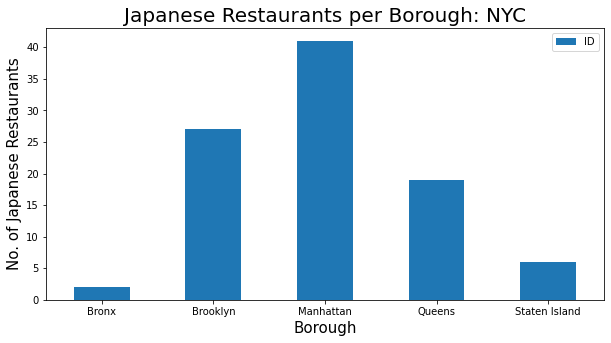

In [37]:
import matplotlib.pyplot as plt

japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

>Now let's calculate how many Japanese restaurants are there in each Neighbourhood.

In [22]:
df_hoods_with_japanese_rest_ny = japanese_rest_ny.groupby('Neighbourhood')['ID'].count().to_frame()

In [23]:
df_hoods_with_japanese_rest_ny

,ID
Neighbourhood,
Astoria,2
Battery Park City,1
Bedford Stuyvesant,1
Belmont,1
Boerum Hill,1
Brooklyn Heights,1
Bulls Head,1
Carnegie Hill,2
Carroll Gardens,1


>Let's rename the COUNT column to make label more descriptive.

In [24]:
df_hoods_with_japanese_rest_ny.rename(columns={"ID":'# of Japanese restaurants'}, inplace = True)
df_hoods_with_japanese_rest_ny.head()

,# of Japanese restaurants
Neighbourhood,
Astoria,2
Battery Park City,1
Bedford Stuyvesant,1
Belmont,1
Boerum Hill,1


>Now we can merge two data frames to obtain information about Neighbourhood's Price Per Sq Foot and Number of Japanese restaurants in the area.

In [26]:
df4 = pd.merge(df2, df_hoods_with_japanese_rest_ny, how='outer', on=['Neighbourhood'])
df4

,Borough,Neighbourhood,Latitude,Longitude,Median Price Per Sq Foot,# of Japanese restaurants
0,Bronx,Wakefield,40.894705,-73.847201,2.08,NaN
1,Bronx,Eastchester,40.887556,-73.827806,2.07,NaN
2,Bronx,Riverdale,40.890834,-73.912585,2.52,NaN
3,Bronx,Kingsbridge,40.881687,-73.902818,2.51,NaN
4,Bronx,Norwood,40.877224,-73.879391,2.13,NaN
5,Bronx,Williamsbridge,40.881039,-73.857446,1.80,NaN
6,Bronx,Pelham Parkway,40.857413,-73.854756,2.17,NaN
7,Bronx,City Island,40.847247,-73.786488,1.88,NaN
8,Bronx,Bedford Park,40.870185,-73.885512,2.07,NaN
9,Bronx,University Heights,40.855727,-73.910416,2.07,NaN


>Let's clean this data by getting rid of NaN values in the 'Borough' column and replacing NaN values in the '# of Japanese restaurants' column with 0.

In [27]:
#replace the missing '# of Japanese restaurants' values by 0
df4["# of Japanese restaurants"].replace(np.nan, 0, inplace=True)

In [28]:
# simply drop whole row with NaN in "Borough" column
df4.dropna(subset=["Borough"], axis=0, inplace=True)

# reset index, because we droped several rows
df4.reset_index(drop=True, inplace=True)

In [29]:
df4

,Borough,Neighbourhood,Latitude,Longitude,Median Price Per Sq Foot,# of Japanese restaurants
0,Bronx,Wakefield,40.894705,-73.847201,2.08,0.0
1,Bronx,Eastchester,40.887556,-73.827806,2.07,0.0
2,Bronx,Riverdale,40.890834,-73.912585,2.52,0.0
3,Bronx,Kingsbridge,40.881687,-73.902818,2.51,0.0
4,Bronx,Norwood,40.877224,-73.879391,2.13,0.0
5,Bronx,Williamsbridge,40.881039,-73.857446,1.80,0.0
6,Bronx,Pelham Parkway,40.857413,-73.854756,2.17,0.0
7,Bronx,City Island,40.847247,-73.786488,1.88,0.0
8,Bronx,Bedford Park,40.870185,-73.885512,2.07,0.0
9,Bronx,University Heights,40.855727,-73.910416,2.07,0.0


## _Pre-processing_

> k-means algorithm isn't directly applicable to categorical variables because Euclidean distance function isn't really meaningful for discrete variables. So, lets drop irrelevant features and run clustering.

In [35]:
dfv1 = df4[['Neighbourhood','Median Price Per Sq Foot','# of Japanese restaurants']]
dfv1.head()

,Neighbourhood,Median Price Per Sq Foot,# of Japanese restaurants
0,Wakefield,2.08,0.0
1,Eastchester,2.07,0.0
2,Riverdale,2.52,0.0
3,Kingsbridge,2.51,0.0
4,Norwood,2.13,0.0


In [39]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = dfv1.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 2, 1, 2, 1, 1], dtype=int32)

>Let's create a new dataframe that includes the cluster as well as the median price and number of Japanese restaurants for each neighbourhood.

In [45]:
# add clustering labels
dfv1.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(dfv1.set_index('Neighbourhood'), on='Neighbourhood')

ny_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Median Price Per Sq Foot,# of Japanese restaurants
0,Bronx,Wakefield,40.894705,-73.847201,1.0,2.08,0.0
1,Bronx,Co-op City,40.874294,-73.829939,NaN,NaN,NaN
2,Bronx,Eastchester,40.887556,-73.827806,1.0,2.07,0.0
3,Bronx,Fieldston,40.895437,-73.905643,NaN,NaN,NaN
4,Bronx,Riverdale,40.890834,-73.912585,1.0,2.52,0.0


>As not all of NYC neighbourhoods had data on Medium Price per Sq Foot in our data source, there are some missing values in the initial **ny_data** data set. Let's proceed to final data cleansing before Cluster Visualization.

In [47]:
# simply drop whole row with NaN in "Cluster" column
ny_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)

# reset index, because we droped two rows
ny_merged.reset_index(drop=True, inplace=True)

ny_merged

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Median Price Per Sq Foot,# of Japanese restaurants
0,Bronx,Wakefield,40.894705,-73.847201,1.0,2.08,0.0
1,Bronx,Eastchester,40.887556,-73.827806,1.0,2.07,0.0
2,Bronx,Riverdale,40.890834,-73.912585,1.0,2.52,0.0
3,Bronx,Kingsbridge,40.881687,-73.902818,1.0,2.51,0.0
4,Bronx,Norwood,40.877224,-73.879391,1.0,2.13,0.0
5,Bronx,Williamsbridge,40.881039,-73.857446,2.0,1.80,0.0
6,Bronx,Pelham Parkway,40.857413,-73.854756,1.0,2.17,0.0
7,Bronx,City Island,40.847247,-73.786488,2.0,1.88,0.0
8,Bronx,Bedford Park,40.870185,-73.885512,1.0,2.07,0.0
9,Bronx,University Heights,40.855727,-73.910416,1.0,2.07,0.0


In [50]:
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].astype('int64')
ny_merged['# of Japanese restaurants'] = ny_merged['# of Japanese restaurants'].astype('int64')
ny_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Median Price Per Sq Foot,# of Japanese restaurants
0,Bronx,Wakefield,40.894705,-73.847201,1,2.08,0
1,Bronx,Eastchester,40.887556,-73.827806,1,2.07,0
2,Bronx,Riverdale,40.890834,-73.912585,1,2.52,0
3,Bronx,Kingsbridge,40.881687,-73.902818,1,2.51,0
4,Bronx,Norwood,40.877224,-73.879391,1,2.13,0


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [48]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## __4. Results__

>Finally, let's visualize the resulting clusters!

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighbourhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## _Examine Clusters_

Now, we can examine each cluster and determine the discriminating features that distinguish each cluster.

### Cluster 1

In [52]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighbourhood,Median Price Per Sq Foot,# of Japanese restaurants
40,Williamsburg,5.15,1
42,Brooklyn Heights,5.40,1
47,Fort Greene,5.19,1
58,Boerum Hill,5.14,1
62,Chinatown,5.00,1
67,Upper East Side,5.03,1
69,Upper West Side,5.53,1
72,Chelsea,6.77,1
73,Chelsea,6.77,1
74,Greenwich Village,6.96,0


>We can see that Neighbourhoods in **Cluster 1** have *high* Median Price per Sq Foot and *medium* number of Japanese restaurants in the area.

### Cluster 2

In [53]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighbourhood,Median Price Per Sq Foot,# of Japanese restaurants
0,Wakefield,2.08,0
1,Eastchester,2.07,0
2,Riverdale,2.52,0
3,Kingsbridge,2.51,0
4,Norwood,2.13,0
6,Pelham Parkway,2.17,0
8,Bedford Park,2.07,0
9,University Heights,2.07,0
11,West Farms,2.00,0
13,Mott Haven,2.62,0


>We can see that Neighbourhoods in **Cluster 2** have *low* Median Price per Sq Foot and almost _no Japanese restaurants in the area_.

### Cluster 3

In [55]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighbourhood,Median Price Per Sq Foot,# of Japanese restaurants
5,Williamsbridge,1.80,0
7,City Island,1.88,0
10,Morris Heights,1.12,0
18,Morris Park,1.88,0
22,Pelham Gardens,1.89,0
23,Concourse,1.22,0
55,Dyker Heights,1.82,0
56,Marine Park,1.87,0
61,Fort Hamilton,2.12,2
87,Howard Beach,2.09,1


>We can see that Neighbourhoods in **Cluster 3** have *low* Median Price per Sq Foot and _low_ number of Japanese restaurants in the area.

### Cluster 4

In [56]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighbourhood,Median Price Per Sq Foot,# of Japanese restaurants
43,Cobble Hill,4.42,2
57,Clinton Hill,3.16,3
70,Murray Hill,5.79,5
71,Murray Hill,5.79,5
78,Little Italy,4.90,2
115,Murray Hill,5.79,5
116,Murray Hill,5.79,5
161,Turtle Bay,4.99,3


>We can see that Neighbourhoods in **Cluster 4** have *high* Median Price per Sq Foot and _high_ number of Japanese restaurants in the area.

### Cluster 5

In [57]:
ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighbourhood,Median Price Per Sq Foot,# of Japanese restaurants
12,Melrose,3.16,0
19,Belmont,3.20,1
29,Greenpoint,3.83,1
36,Kensington,2.77,1
37,Windsor Terrace,3.36,0
38,Prospect Heights,4.00,1
44,Carroll Gardens,3.67,1
45,Red Hook,3.21,0
46,Gowanus,4.07,0
48,Park Slope,3.56,1


>We can see that Neighbourhoods in **Cluster 5** have *medium* Median Price per Sq Foot and _medium_ number of Japanese restaurants in the area.

## __5. Discussion__

There are several options for potential improvement of the analysis results:

- to add an extra step of finding an optimal value of K for clustering purposes (e.g. using the Elbow method).
- to add other features for analysis (e.g. average rating of the restaurants in the neighbourhood etc.)

## **6. Conclusion**

- Cluster 1: high rental price & medium competition/demand
- Cluster 2: low rental price & no competition/demand
- Cluster 3: low rental price & low competition/demand
- Cluster 4: high rental price & high competition/demand
- Cluster 5: medium rental price & medium competition/demand

Out of the Cluster descriptions outlined above, **any neigborhood in Cluster 5** that doesn't have a Japanese restaurant yet seems to be the most attractive option for investment, although this choice highly depends on the investor's budget. 